## Pydna Gel Electrophoresis Simulation

In [1]:
%matplotlib inline

import pydna
from Bio.Restriction import BamHI, EcoRV
from pydna import Gel, gen_sample, weight_standards, weight_standard_sample, lin_div_Qty, random_Dseqs, Q_

pydna.delete_cache()

# For convenience
def printQ(quantities):
    for Q in quantities:
        print Q

def printN(samples):
    for sample in samples:
        print Q_([seq.n for seq in sample], 'mol').to('pmol')

### Simple Reconstruction Experiment (for context)

In [2]:
gb = pydna.Genbank("pg25220@alunos.uminho.pt") # Tell Genbank who you are!

In [3]:
# Gene
gene = gb.nucleotide("X06997") # Kluyveromyces lactis LAC12 gene for lactose permease.

In [4]:
# Primers
primer_f, primer_r = pydna.parse(''' >760_KlLAC12_rv (20-mer)
                                     ttaaacagattctgcctctg

                                     >759_KlLAC12_fw (19-mer)
                                     aaatggcagatcattcgag
                                     ''', ds=False)

In [5]:
# PCR
pcr_prod = pydna.pcr(primer_f, primer_r, gene)

In [6]:
# Vector
vector = gb.nucleotide("AJ001614") # pCAPs cloning vector

In [7]:
# Linearized vector
lin_vector = vector.linearize(EcoRV)

In [8]:
# Reconstructed vector (linearized vector + pcr product)
rec_vec = (lin_vector + pcr_prod).looped()

In [9]:
print len(pcr_prod),
print len(rec_vec),
print len(lin_vector)

1766 4894 3128


### Sample for Electrophoresis

List of `pydna` **`Dseqrecord`**s or **`Dseq`**s.

In [10]:
# realistic sample
sample1 = [pcr_prod, rec_vec, lin_vector]

print sample1

[Amplicon(1766), Dseqrecord(o4894), Dseqrecord(-3128)]


#### Default quantities

* Each **`Dseq`** object has a **`mw()`** method that returns its approximate molecular weight (**g/mol**) as determined from its sequence.

* Each **`Dseqrecord`** object has a **`n`** property set to a default value (**mol**).

* Each **`Dseqrecord`** object has a **`m()`** method that returns its mass (**g**) as given by **`Dseqrecord.seq.mw() * Dseqrecord.n`**.

In [11]:
print Q_([seq.n for seq in sample1], 'mol').to('pmol')  # pmol
print Q_([seq.m() for seq in sample1], 'g').to('ng')    # ng

[ 0.05  0.05  0.05] pmol
[  54.55532  151.19348   96.64211] ng


### Random Dseqs

Return a list of pydna Dseqs of given sizes and random sequences.

**`random_Dseqs(sizes)`**

In [12]:
# samples of random sequences
sample2 = random_Dseqs([500, 1000, 5000])
sample3 = random_Dseqs([3000, 1500])

print sample2

[Dseq(-500)
cgta..ctgg
gcat..gacc, Dseq(-1000)
atta..ctcg
taat..gagc, Dseq(-5000)
ctag..ccat
gatc..ggta]


# Gel class

### `Gel(samples, names, percentgel=Q_(1.0, 'g/ml'), electrfield=Q_(5.0, 'V/cm'), ...)`

### `G.run(till_len=0.75, till_time=None, exposure=0.5, ...)`

 - Agarose slab gel electrophoresis.
 - Returns a **`matplotlib.pyplot`** object.

**Notes:**
* Converts **`Dseqs`** into **`Dseqrecords`** with the default quantity (**`n`**).
* Uses **`Dseqrecord.m()`** to get each band's DNA quantity. This quantity is related to the area underneath the signal intensity curve.

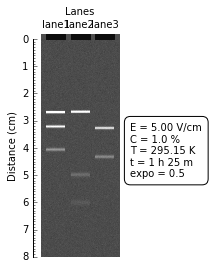

In [13]:
# Samples (each sample is loaded to a different well)
samples = [sample1, sample2, sample3]

# Instantiate Gel
G = Gel(samples)

# Run Electrophoresis
gelpic = G.run()

# Show gel picture
gelpic.show()

In [14]:
# DNA quantity in each band (ng) 
printQ(G.quantities)

[  54.55532  151.19348   96.64211] ng
[  15.4511    30.89845  154.47785] ng
[ 92.68775  46.3464 ] ng


In [15]:
# DNA quantity in each band (pmol) 
printN(G.samples)

[ 0.05  0.05  0.05] pmol
[ 0.05  0.05  0.05] pmol
[ 0.05  0.05] pmol


### Weight standards

**`weight_standard_sample(key, qty=<Quantity(500, 'nanogram')>)`**

Creates a sample respecting the sizes and mass fractions of the ladder standards stored in the dictionary **`weight_standards`**.

In [16]:
# Weight standards stored
weight_standards.keys()

['Mix_GeneRuler', '1kb+_GeneRuler', 'High_Range_GeneRuler', '1kb_GeneRuler']

In [17]:
ladder = weight_standard_sample('1kb_GeneRuler')  # total = 500 ng
print ladder

[Dseqrecord(-10000), Dseqrecord(-8000), Dseqrecord(-6000), Dseqrecord(-5000), Dseqrecord(-4000), Dseqrecord(-3500), Dseqrecord(-3000), Dseqrecord(-2500), Dseqrecord(-2000), Dseqrecord(-1500), Dseqrecord(-1000), Dseqrecord(-750), Dseqrecord(-500), Dseqrecord(-250)]


In [18]:
print Q_([seq.n for seq in ladder], 'mol').to('pmol')  # pmol
print Q_([seq.m() for seq in ladder], 'g').to('ng')    # ng

[ 0.00485508  0.00606874  0.0188808   0.00971023  0.01213747  0.01387123
  0.03776064  0.01618262  0.02022853  0.02697087  0.09709005  0.05393825
  0.08089908  0.16175262] pmol
[ 30.  30.  70.  30.  30.  30.  70.  25.  25.  25.  60.  25.  25.  25.] ng


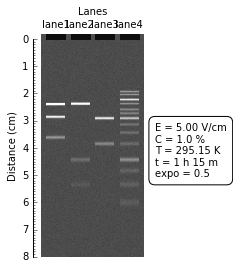

In [19]:
samples = [sample1, sample2, sample3, ladder]
G = Gel(samples)
gelpic = G.run()
gelpic.show()

### Assigning Quantities

**`gen_sample(sizes, quantities)`**

Return list of pydna Dseqrecords of given size and quantity.


#### Direct Assignment

**Note:** If no units are provided, nanograms are assumed.

In [20]:
sizes3 = [3000, 1500]  # bp
qts3 = [100, 100]  # ng
sample3 = gen_sample(sizes3, qts3)

print sample3
print Q_([seq.n for seq in sample3], 'mol').to('pmol')  # pmol
print Q_([seq.m() for seq in sample3], 'g').to('ng')    # ng

[Dseqrecord(-3000), Dseqrecord(-1500)]
[ 0.05394378  0.10788394] pmol
[ 100.  100.] ng


#### Assigning Total Quantity

**Note:** For fragments resulting from a digestion with restriction enzyme procedure, for example, the mass of the fragments is proportional to their size. Lets assume that is the case and that we have a total mass of 200 ng.

In [21]:
sizes2 = Q_([0.5, 1, 5], 'kbp')  # this time with declared units
totalQ2 = Q_(200, 'ng')
sample2 = gen_sample(sizes2, totalQ2)

print sample2
print Q_([seq.n for seq in sample2], 'mol').to('pmol')  # pmol
print Q_([seq.m() for seq in sample2], 'g').to('ng')    # ng
print sum(Q_([seq.m() for seq in sample2], 'g').to('ng'))

[Dseqrecord(-500), Dseqrecord(-1000), Dseqrecord(-5000)]
[ 0.04978163  0.04979122  0.04979555] pmol
[  15.38461538   30.76923077  153.84615385] ng
200.0 ng


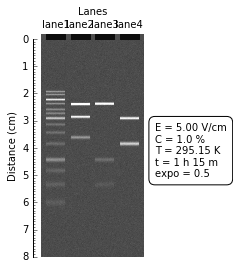

In [22]:
samples = [ladder, sample1, sample2, sample3]
G = Gel(samples)
gelpic = G.run()
gelpic.show()

In [23]:
printQ(G.quantities)

[ 30.  30.  70.  30.  30.  30.  70.  25.  25.  25.  60.  25.  25.  25.] ng
[  54.55532  151.19348   96.64211] ng
[  15.38461538   30.76923077  153.84615385] ng
[ 100.  100.] ng


In [24]:
printN(G.samples)

[ 0.00485508  0.00606874  0.0188808   0.00971023  0.01213747  0.01387123
  0.03776064  0.01618262  0.02022853  0.02697087  0.09709005  0.05393825
  0.08089908  0.16175262] pmol
[ 0.05  0.05  0.05] pmol
[ 0.04978163  0.04979122  0.04979555] pmol
[ 0.05394378  0.10788394] pmol


### Stop Criteria

**`till_len`**
* Fraction of the gel length (measured from the well bottom) to
serve as finish line. Defaults to 0.75.

**`till_time`**
* Time (in hours) at which to stop the electrophoresis. Defaults to None.

**Note:** If both conditions are given the most stringent will be respected.

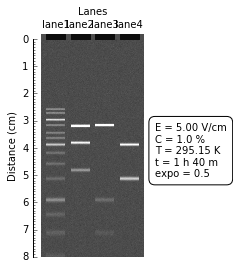

In [25]:
G = Gel(samples)
gelpic = G.run(till_len=1)
gelpic.show()

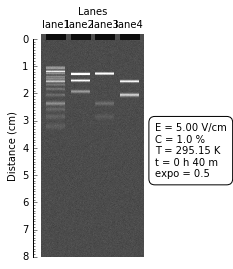

In [26]:
G = Gel(samples)
gelpic = G.run(till_len=0.4)
gelpic.show()

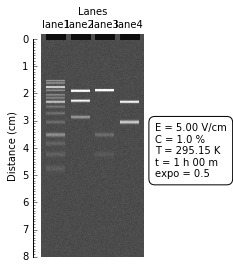

In [27]:
G = Gel(samples)
gelpic = G.run(till_time=Q_(1,'hr'))
gelpic.show()

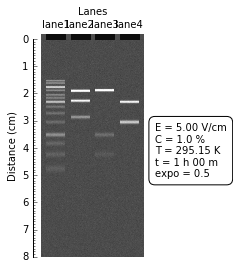

In [28]:
G = Gel(samples)
gelpic = G.run(till_len=0.8, till_time=Q_(1,'hr'))
gelpic.show()

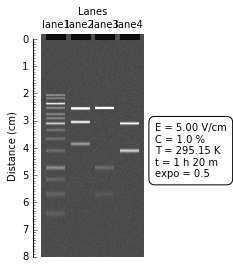

In [29]:
G = Gel(samples)
gelpic = G.run(till_len=0.8, till_time=Q_(3,'hr'))
gelpic.show()

### Exposure effect

Fraction of signal saturation (0-1).

If exposure is set to 0 every band's light intensity will be given by a perfect Gaussian curve. Wider bands with lower
amounts of DNA might be hard to see.

The closer to 1 the exposure the higher the saturation, which favors the weaker bands visualization.

If exposure is set to 1 only the weakest band will be a Gaussian, all others will be saturated.

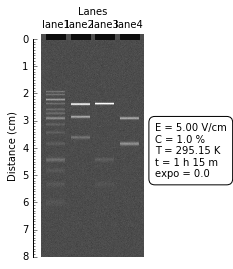

In [30]:
G = Gel(samples)
gelpic = G.run(exposure=0)
gelpic.show()

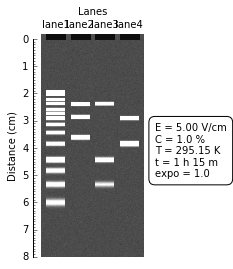

In [31]:
G = Gel(samples)
gelpic = G.run(exposure=1)
gelpic.show()

### Agarose Concentration

**`percentgel`**

* Agarose concentration in the gel.
* Defaults to Q_(1.0, '(g/(100 mL))*100').


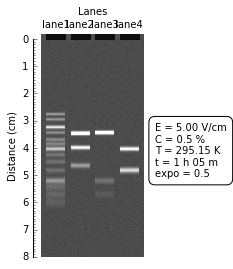

In [32]:
G = Gel(samples, percentgel=0.5)
gelpic = G.run()
gelpic.show()

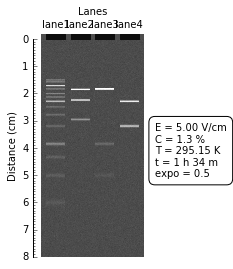

In [33]:
G = Gel(samples, percentgel=1.3)
gelpic = G.run()
gelpic.show()

### Electric Field Intensity

**`electrfield`**
* Defaults to Q_(5.0, 'V/cm').

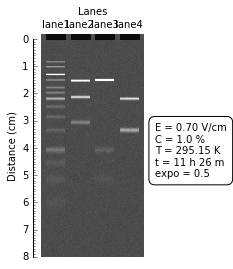

In [34]:
G = Gel(samples, electrfield=0.7)
gelpic = G.run()
gelpic.show()
# Notice the time.

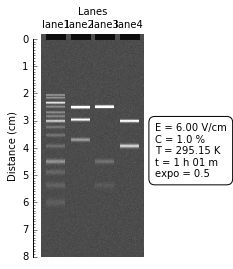

In [35]:
G = Gel(samples, electrfield=Q_(6.0, 'V/cm'))
gelpic = G.run()
gelpic.show()
# Notice the time.